In [1]:
%matplotlib inline
import Utilities.raster_utils as rast
import Utilities.stats_utils as stats
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats.kde import gaussian_kde
from sklearn import cluster as Kclust, metrics
from sklearn import preprocessing

In [25]:
base_str = 'Imagery_Data/L8'

def multi_img_to_array(multi_image_list):
    ravel_list = map(np.ravel, multi_image_list)
    return np.array(ravel_list)

def normalize_(imgs):
    return preprocessing.normalize(imgs, norm='l2', axis=1)

#################
# Load the data #
#################

#Ground truth data
NLCD = rast.read_raster('Imagery_Data/NLCD_2011.tif')

#Get TOA reflectance for the red and NIR bands
GREEN = rast.transform_TOA(base_str, 3)
RED = rast.transform_TOA(base_str, 4)
NIR = rast.transform_TOA(base_str, 5)
SWIR = rast.transform_TOA(base_str, 6)
TIR = rast.transform_sat_brightness_temp(base_str, 11)

#Wide Dynamic Range Veg Index
WDRVI = rast.calc_normalized_diff(NIR, RED, alpha=0.2)
#Normalized Diff Water Index
NDWI = rast.calc_normalized_diff(GREEN, NIR, alpha=1.0)

NISI_ = rast.NISI(GREEN, SWIR, NIR, TIR)


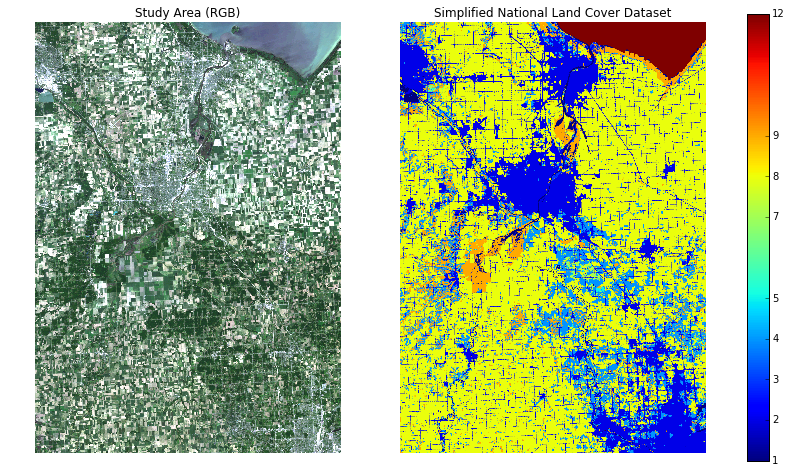

In [56]:
#######################################################
#From the NLCD FAQ: file:///Users/john/Downloads/land_use_land_cover_NLCD_mbr_3038831_01/land_use_land_cover%5Cnlcd_2011_faq.html
#
#The simplified land cover types are:
# - 1: Water
# - 2: Developed land
# - 3: Barren
# - 4: Forest
# - 5: Scrub
# - 7: Grassland
# - 8: Agricultural Land
# - 9: Wetland
# - 12: No Data (Lake Huron)
#######################################################

def group_NLCD(array):
    return (array / 10).astype(int)

simple_NLCD = group_NLCD(NLCD)

plt.figure(figsize = (15,10))
image = rast.get_multiband_array(base_str, bn=(4,3,2), enhance='stretch_histogram', gamma=1.25, percentile=95)
ax1 = plt.subplot(121)
ax1.imshow(image);
ax1.set_title('Study Area (RGB)');
ax1.set_axis_off()

ax2 = plt.subplot(122)
ax2.imshow(simple_NLCD, cmap='Set2');
ax2.set_title('Simplified National Land Cover Dataset');
ax2.set_axis_off()

#Add legend
plt.colorbar(plt.imshow(simple_NLCD), ax=[ax1, ax2], ticks=np.unique(simple_NLCD).tolist(), shrink=0.8);

#To do: Add discrete legend

In [26]:
#Build the test and training datasets for our model
test = np.dstack((simple_NLCD,WDRVI, NDWI, NISI_))[:, :850]
train = np.dstack((simple_NLCD,WDRVI, NDWI, NISI_))[:,850:]

#NLCD value `128` is a no data value (Lake Huron far from the shore) removing from the training data
train_sample = np.array(stats.two_step_sample(train, 10000, (50,50)))
train_sample = np.delete(train_sample, np.where(train_sample[:,0]==12)[0], axis=0)
test_sample = np.array(stats.two_step_sample(test, 10000, (50,50)))


### Data Overview

Let's take a look at the distributions of the data for each of the variables we are using in our model:
* WDRVI: Wide Dynamic Range Vegetative Index
* NDWI: Normalized Difference Water Index
* NISI: Normalized Impervious Surface Index

Each of these is meant to capture a different feature of the landscape (Vegetation, Water, Impervious surfaces), so we should expect to see some seperation between the primary land cover types.

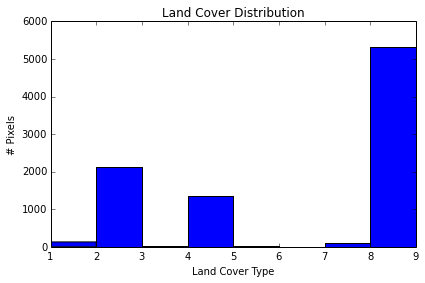

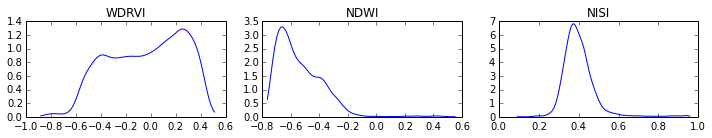

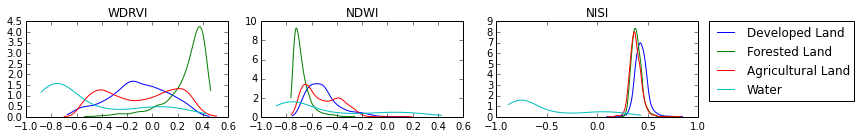

In [59]:
def subset(array, grp):
    return array[np.where(array[:,0]==grp)]

#Full Data Set Distribution
plt.hist(train_sample[:,0], 8);
plt.title('Land Cover Distribution')
plt.ylabel('# Pixels')
plt.xlabel('Land Cover Type')
plt.tight_layout()

#Data distribution for each feature
prob_dens = map(stats.density,[train_sample[:,1],train_sample[:,2],train_sample[:,3]])
plt.figure(figsize = (10,2))
ax1 = plt.subplot(131)
ax1.plot(prob_dens[0][0],prob_dens[0][1])
ax1.set_title('WDRVI')
ax2 = plt.subplot(132)
ax2.plot(prob_dens[1][0],prob_dens[1][1])
ax2.set_title('NDWI')
ax3 = plt.subplot(133)
ax3.plot(prob_dens[2][0],prob_dens[2][1])
ax3.set_title('NISI')
plt.tight_layout()

######################################
# Distributions by land cover type   #
######################################

sub_water = subset(train_sample, 1)
sub_developed = subset(train_sample, 2)
sub_forest = subset(train_sample, 4)
sub_ag = subset(train_sample, 8)

#set up the plot
plt.figure(figsize = (10,2))

#WDRVI curves
WDRVI_prob_dens = map(stats.density,[sub_developed[:,1],sub_forest[:,1],sub_ag[:,1],sub_water[:,1]])
ax1 = plt.subplot(131)
ax1.plot(WDRVI_prob_dens[0][0], WDRVI_prob_dens[0][1])
ax1.plot(WDRVI_prob_dens[1][0], WDRVI_prob_dens[1][1])
ax1.plot(WDRVI_prob_dens[2][0], WDRVI_prob_dens[2][1])
ax1.plot(WDRVI_prob_dens[3][0], WDRVI_prob_dens[3][1])
ax1.set_title('WDRVI')

#NDWI Curves
NDWI_prob_dens = map(stats.density,[sub_developed[:,2],sub_forest[:,2],sub_ag[:,2],sub_water[:,1]])
ax2 = plt.subplot(132)
ax2.plot(NDWI_prob_dens[0][0], NDWI_prob_dens[0][1])
ax2.plot(NDWI_prob_dens[1][0], NDWI_prob_dens[1][1])
ax2.plot(NDWI_prob_dens[2][0], NDWI_prob_dens[2][1])
ax2.plot(NDWI_prob_dens[3][0], NDWI_prob_dens[3][1])
ax2.set_title('NDWI')

#NISI Curves
NISI_prob_dens = map(stats.density,[sub_developed[:,3],sub_forest[:,3],sub_ag[:,3],sub_water[:,1]])
ax3 = plt.subplot(133)
ax3.plot(NISI_prob_dens[0][0], NISI_prob_dens[0][1], label='Developed Land')
ax3.plot(NISI_prob_dens[1][0], NISI_prob_dens[1][1], label='Forested Land')
ax3.plot(NISI_prob_dens[2][0], NISI_prob_dens[2][1], label='Agricultural Land')
ax3.plot(NISI_prob_dens[3][0], NISI_prob_dens[3][1], label='Water')
ax3.set_title('NISI')

ax3.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

Looking at the breakout of each feature by the land cover type, we can see there is not a lot of seperation between the land cover types in NISI. WDRVI and NDWI are better, but not great. An interesting note: agricultural land has a bimodal distribution in both WDRVI and NDWI, possibly due to the 

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

#Build a random forest model

rf_model = RandomForestClassifier(n_estimators=100, criterion="entropy",oob_score=True,max_features="sqrt",random_state=53478,min_samples_split=10)
rf_model.fit(train_sample[:,1:],train_sample[:,0])
print 'Score: ', rf_model.score(test_sample[:,1:], test_sample[:,0])

#to do: Clean up the confusuon matrix output
#y_pred = rf_model.predict(test_sample[:,1:])
#confusion_matrix(y_pred, test_sample[:,0])

Score:  0.678272222827


In [36]:
pred_image = np.copy(test[:,:,0])
_x,_y = np.where(~np.isnan(test[:,:,1]))
pred_image[_x,_y] = rf_model.predict(test[_x,_y,1:])

Let's take a look at the predicted land cover image. There is a clear relationship between the two images (predicted and actual), but we are overestimating cultivated land at the exenpense of developed land.

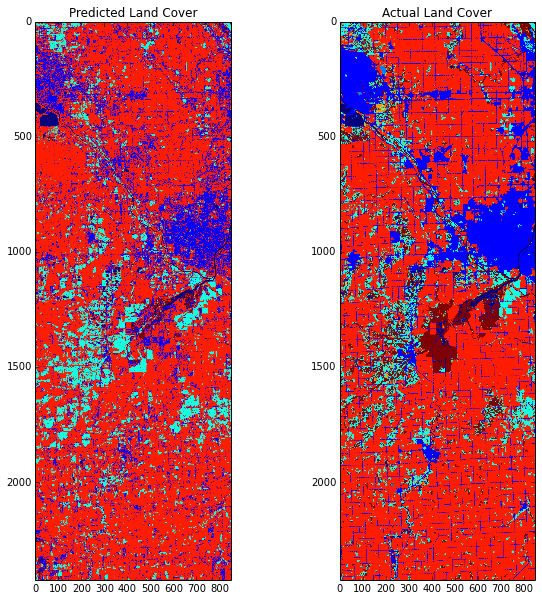

In [38]:
#plot the 1) predicted landcover 2) actual land cover
#To Do: set color map to the one used above, add legend
plt.figure(figsize = (10,10))
ax1 = plt.subplot(121)
ax1.imshow(pred_image)
ax1.set_title('Predicted Land Cover')
ax2 = plt.subplot(122)
ax2.imshow(test[:,:,0])
ax2.set_title('Actual Land Cover')